In [37]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

def U_timeseries(dirname, fname, x_start, x_end, y_start, y_end):
    
    filesU = get_files(dirname, fname, 'grid_U')
    
    y = slice(y_start, y_end, None)
    x = slice(x_start, x_end, None)

    with scDataset(filesU) as dsU:
        vozocrtx0 = dsU.variables['vozocrtx'][:,:,y,x]
        #print('U')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]

    umask = np.tile(umask0, (len(sozotaux),1, 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    return vozocrtx, umask, depthu, sozotaux

def load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end):
    
    # load masks for wheat in final plot
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask_all = dsM.variables['umask'][0,:,:,:]

    # load grid_U files and U velocity (t, z, y, x)
    vozocrtx, umask, depthu, sozotaux = U_timeseries(dirname, fname, x_start, x_end, y_start, y_end)

    return vozocrtx, umask, umask_all, depthu, sozotaux

def calculate_avgU(vozocrtx, dep_start, dep_end):

    # find avg U for every row in the y direction
    avgU_all_ys = np.mean(np.mean(vozocrtx, axis=-1), axis=-2)

    # find avg U within horizontal rectangle for all depths (time, z)
    avgU_all_depths = np.mean(np.mean(vozocrtx, axis=-1), axis=-1)

    # find avg U for every depth within the box
    avgU_box_depths = avgU_all_depths[:, dep_start : dep_end+1]

    # find the absolute avg U within the box
    avgU_absolute = np.mean(avgU_box_depths, axis=-1)
    
    return avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute

def plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute):
    cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

    xs = np.arange(umask_all.shape[-1]) * 2/3
    ys = np.arange(umask_all.shape[-2]) *2/3
    zs = np.arange(umask_all.shape[-3])

    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])

    ax1 = plt.subplot(gs[0])
    ax4 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[3])

    s = ax1.pcolormesh(xs, ys, umask_all[9, :,:], cmap=cmap)
    ax1.set_aspect(aspect='equal')
    ax1.add_patch(patches.Rectangle((x_start*2/3, y_start*2/3),(x_end-x_start)*2/3,(y_end-y_start)*2/3, 
                                    fill=False, linewidth=3))
    ax1.set_xlim([0, xs[-1]])
    ax1.set_ylim([0, ys[-1]])
    ax1.set_xlabel('Alongshore Distance [km]', fontsize = 15)
    ax1.set_ylabel('Cross-shore Distance [km]', fontsize = 15)

    sc = ax3.pcolormesh(ys, zs, umask_all[:, :, x_start], cmap=cmap)
    ax3.add_patch(patches.Rectangle((y_start*2/3, dep_start),(y_end-y_start)*2/3, dep_end-dep_start, fill=False, linewidth=3))
    ax3.set_ylim([zs[-1], 0])
    ax3.set_xlim([0, ys[-1]])
    ax3.set_ylabel('Z Indices', fontsize = 15)
    ax3.set_xlabel('Cross-shore Distance [km]', fontsize = 15)

    avgU_absolute_smoothed = general_functions.smooth(avgU_absolute[:], 12)
    ax2.plot(avgU_absolute, c='gray', lw=2, alpha=0.8)
    ax2.plot(avgU_absolute_smoothed, c='k', lw=2)
    ax2.set_title('Incoming Velocity', fontsize=20)
    ax2.set_xlabel('Time [hours]', fontsize=15)
    ax2.set_ylabel('[ms$^{-1}$]', fontsize=20)
    ax2.set_xlim([0, 480])
    ax2.set_ylim([-0.3, 0.3])
    ml = MultipleLocator(24)
    ax2.xaxis.set_minor_locator(ml)
    ax2.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax2.axhline(0, linestyle='--', c='gray')

    ax4.plot(sozotaux, c='k', lw=2)
    ax4.set_title('Wind Stress', fontsize=20)
    ax4.set_xlabel('Time [hours]', fontsize=15)
    ax4.set_ylabel('[Nm$^{-2}$]', fontsize=20)
    ax4.set_xlim([0, 480])
    ax4.set_ylim([-1.0, 1.0])
    ml = MultipleLocator(24)
    ax4.xaxis.set_minor_locator(ml)
    ax4.xaxis.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax4.axhline(0, linestyle='--', c='gray')

    fig.tight_layout(w_pad=5.5, h_pad=3.5)
    
    print('min unsmoothed: ', avgU_absolute.min())
    print('min smoothed: ', avgU_absolute_smoothed.min())
    return fig

min unsmoothed:  -0.286296630452
min smoothed:  -0.25792348731


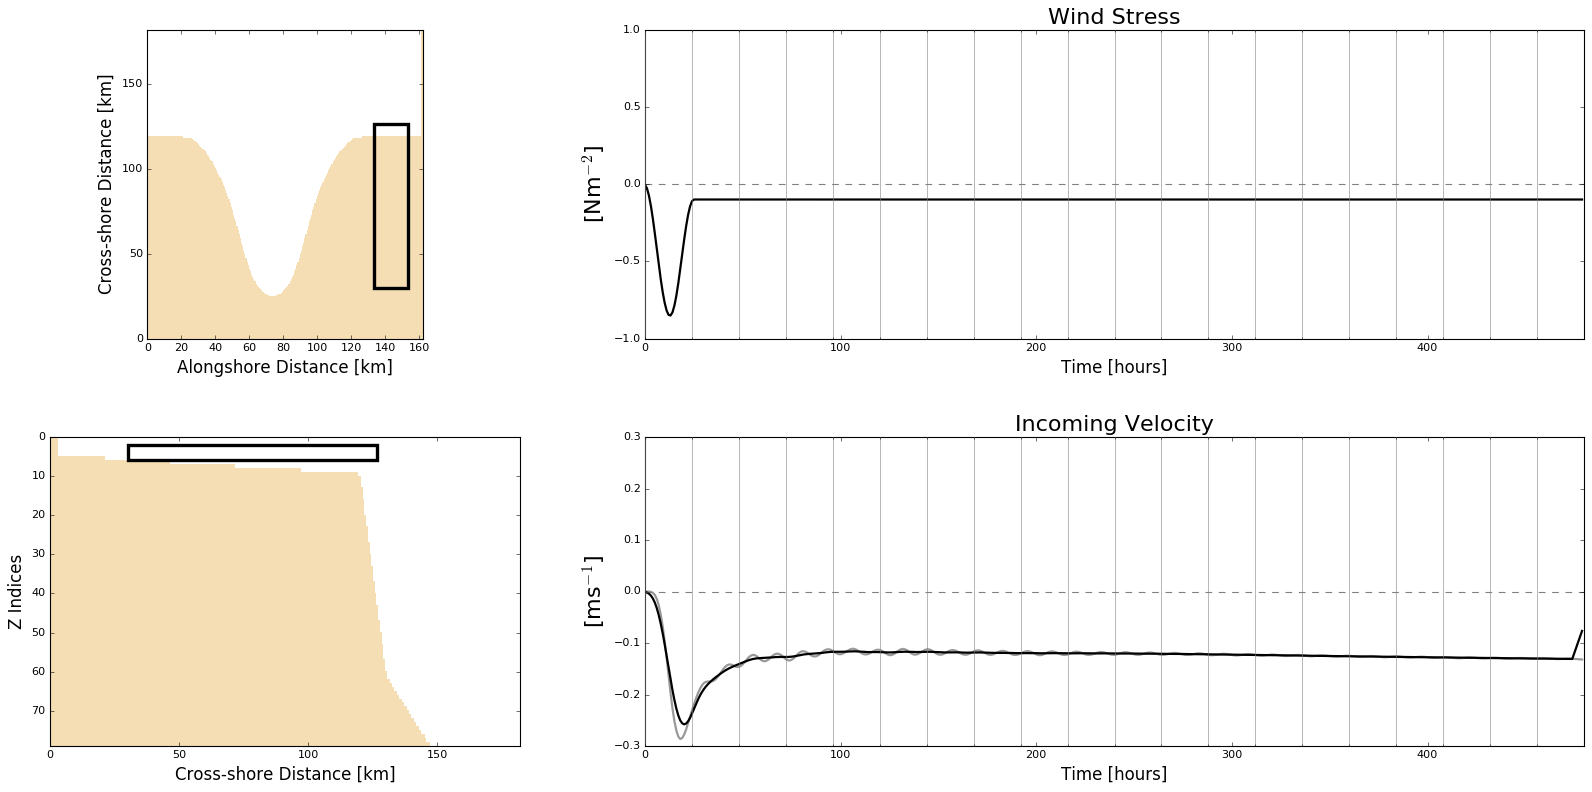

In [11]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

x_start = 200; x_end = 230; y_start = 45; y_end = 190
dep_start = 2; dep_end = 6; dep_break = 9

vozocrtx, umask, umask_all, depthu, sozotaux = load_vozocrtx(dirname, fname, x_start, x_end, y_start, y_end)

avgU_all_ys, avgU_all_depths, avgU_box_depths, avgU_absolute = calculate_avgU(vozocrtx, dep_start, dep_end)

fig = plot_story(umask_all, y_start, y_end, x_start, x_end, dep_start, dep_end, avgU_absolute)

In [45]:
def get_vars_at_depth_time(dirname, fname, depth_ind, time_ind):
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        
        vosaline0 = dsT.variables['vosaline'][time_ind, depth_ind, y, x]
        vosaline0_orig = dsT.variables['vosaline'][0, depth_ind, y, x]
        
        vozocrtx0 = dsU.variables['vozocrtx'][time_ind,depth_ind,y,x]
        
        vomecrty0 = dsV.variables['vomecrty'][time_ind,depth_ind,y,x]
        
        vovecrtz0 = dsW.variables['vovecrtz'][time_ind,depth_ind,y,x]
        
        sozotaux = dsU.variables['sozotaux'][time_ind,0,0]
        deptht = dsT.variables['deptht'][depth_ind]
          
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, depth_ind, y, x]
        umask0 = dsM.variables['umask'][0,depth_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,depth_ind,y,x]
        
    tmask = np.tile(tmask0, (1, 1, 1))  
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    vosaline_orig = np.ma.array(vosaline0_orig, mask=1 - tmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    umask = np.tile(umask0, (1, 1, 1))  
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    
    vmask = np.tile(vmask0, (1, 1, 1))  
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    
    return vosaline, vosaline_orig, vozocrtx, vomecrty, vovecrtz, sozotaux, deptht

def get_sal_cross_mer(dirname, x_ind, time_ind, z_cut):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y = slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        vosaline0 = dsT.variables['vosaline'][time_ind, :z_cut, y, x_ind]
        deptht_c = dsT.variables['deptht'][:z_cut]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :z_cut, y, x_ind]
        
    tmask = np.tile(tmask0, (1 ,1, 1))  
    vosaline_c = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline_c, tmask0, deptht_c

def get_sal_cross_zon(dirname, y_ind, time_ind, z_cut):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    x = slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        vosaline0 = dsT.variables['vosaline'][time_ind, :z_cut, y_ind, x]
        deptht_c = dsT.variables['deptht'][:z_cut]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :z_cut, y_ind, x]
        
    tmask = np.tile(tmask0, (1 ,1, 1))  
    vosaline_c = np.ma.array(vosaline0, mask=1 - tmask)
    
    vosaline_c2, tmask02, deptht_c2 = vosaline_c, tmask0, deptht_c
    
    return vosaline_c2, tmask02, deptht_c2

In [46]:
depth_ind = 9
time_ind = (24*3)+8

vosaline, vosaline_orig, vozocrtx, vomecrty, vovecrtz, sozotaux, deptht = get_vars_at_depth_time(dirname, fname, depth_ind, time_ind)

salt_anom = vosaline - vosaline_orig

In [47]:
z_cut = depth_ind + 6
x_ind = 120
vosaline_c, tmask_c, deptht_c = get_sal_cross_mer(dirname, x_ind, time_ind, z_cut)

y_ind = 60
vosaline_c2, tmask02, deptht_c2 = get_sal_cross_zon(dirname, y_ind, time_ind, z_cut)

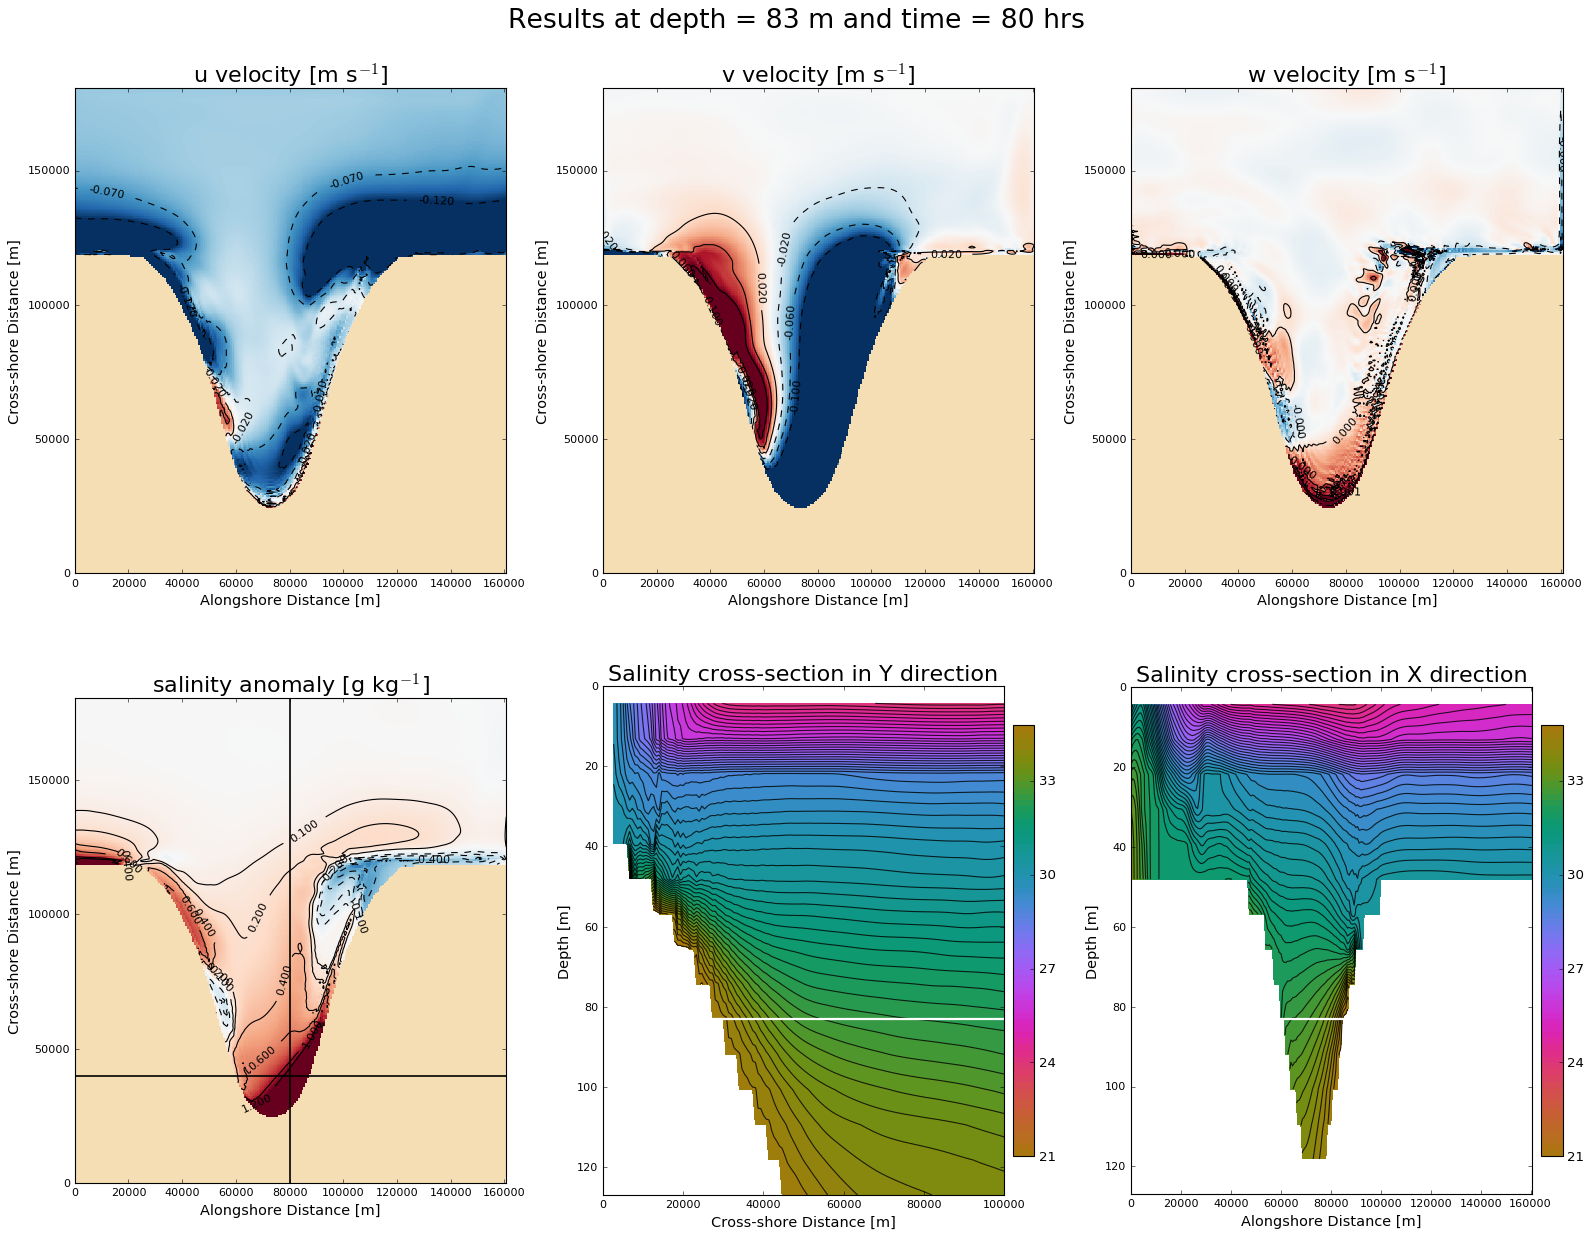

In [49]:
cmap = plt.get_cmap(cm.RdBu_r)
cmap.set_bad('wheat')
    
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(20, 16))

levelsU = [-0.12, -0.07, -0.02, 0.02, 0.07, 0.12]
levelsV = [-0.1, -0.06, -0.02, 0.02, 0.06, 0.1]
levelsW = [-0.0006, -0.0004, -0.0001, 0.0001, 0.0004, 0.0006]
levelsSA = [-1.2, -1.0, -0.6, -0.4, -0.2, -0.1, 0.1, 0.2, 0.4, 0.6, 1.0, 1.2]

axes = [ax1, ax2, ax3, ax4]
values = [vozocrtx, vomecrty, vovecrtz, salt_anom]
levels_all = [levelsU, levelsV, levelsW, levelsSA]
ttls = ['u velocity [m s$^{-1}$]', 'v velocity [m s$^{-1}$]', 'w velocity [m s$^{-1}$]', 'salinity anomaly [g kg$^{-1}$]']

for ax, value, levels, ttl, n in zip(axes, values, levels_all, ttls, np.arange(4)):
    ax, xs, ys = general_functions.set_xy(ax, value, 'childm')
    #ax.pcolormesh(value)
    P = ax.pcolormesh(xs, ys, value, vmin = levels[0], vmax = levels[-1], cmap=cmap)
    cs = ax.contour(xs, ys, value, levels = levels, colors='k')
    ax.clabel(cs, inline=1, fontsize=10)
    ax.set_aspect(aspect='equal')
    #cbar = plt.colorbar(P, ax=ax, fraction=0.05, pad=0.02, orientation='vertical')
    #cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0, fontsize=12)
    #tick_locator = ticker.MaxNLocator(nbins=5)
    #cbar.locator = tick_locator
    #cbar.update_ticks()
    ax.set_title(ttl, fontsize=20)
    ax.set_ylabel('Cross-shore Distance [m]', fontsize=13)
    ax.set_xlabel('Alongshore Distance [m]', fontsize=13)

levels = np.arange(21,35, 0.2)
cmap = plt.get_cmap(cmo.cm.phase)#plt.cm.get_cmap('gist_earth_r')

c5 = ax5.contourf(ys, deptht_c, vosaline_c, levels = levels, cmap = cmap)
ax5.contour(ys, deptht_c, vosaline_c, levels = levels, colors = 'k', alpha=0.8)
ax5.set_xlim([0, 100000])
ax5.set_ylim([deptht_c[-1], 0])
ax5.set_aspect(aspect=1000)
ax5.set_xlabel('Cross-shore Distance [m]', fontsize=13)

c6 = ax6.contourf(xs, deptht_c2, vosaline_c2, levels = levels, cmap = cmap)
ax6.contour(xs, deptht_c2, vosaline_c2, levels = levels, colors = 'k', alpha=0.8)
ax6.set_xlim([0, xs[-1]])
ax6.set_ylim([deptht_c2[-1], 0])
ax6.set_aspect(aspect=1600)
ax6.set_xlabel('Alongshore Distance [m]', fontsize=13)

for ax, c, n in zip([ax5, ax6], [c5, c6], np.arange(2)):
    ax.axhline(deptht, c='w', lw=2)
    cbar = plt.colorbar(c, ax=ax, fraction=0.05, pad=0.02, orientation='vertical')
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=0, fontsize=12)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    ax.set_ylabel('Depth [m]', fontsize=13)

ax4.axhline(ys[y_ind], c='k', lw=1.5)
ax4.axvline(xs[x_ind], c='k', lw=1.5)

ax5.set_title('Salinity cross-section in Y direction', fontsize=20)
ax6.set_title('Salinity cross-section in X direction', fontsize=20)
    
plt.tight_layout(h_pad=1.4, w_pad=0.9)
fig.suptitle('Results at depth = '+str(int(deptht))+' m and time = '+str(time_ind) + ' hrs', fontsize=24)
plt.subplots_adjust(top=0.95)

In [44]:
def get_vars_at_depth(dirname, fname, dep_ind):
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    filesW = get_files(dirname, fname, 'grid_W')
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        vozocrtx0 = dsU.variables['vozocrtx'][:,dep_ind,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][:,dep_ind,y,x]
        print('V')
        vovecrtz0 = dsW.variables['vovecrtz'][:,dep_ind,y,x]
        print('W')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,dep_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,dep_ind,y,x]
        tmask0 = dsM.variables['tmask'][0,dep_ind,y,x]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    return vozocrtx, vomecrty, vovecrtz, umask, vmask, tmask, depthu, sozotaux

def get_1day_avg(vel, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    vel_day = np.mean(vel[day, ...], axis=0)
    return vel_day

def plot_vel_snapshots(vel_all, xs, ys, vm, ttl):
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('wheat')
    fig, axes = plt.subplots(3, 5, figsize=(20,15), sharey=True)
    for ax, n in zip(axes.flatten(), np.arange(15)):
        vel_dayn = get_1day_avg(vel_all, n, n+1)
        p = ax.pcolormesh(xs, ys, vel_dayn, vmin=-1*vm, vmax=vm, cmap=cmap)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xlim([0, xs[-1]])
        ax.set_ylim([0, ys[-1]])
        ax.set_title('Day '+str(n+1), fontsize=16)
        if n==0:
            fig.colorbar(p, ax=ax)
    fig.tight_layout(w_pad=0.1, h_pad=0.25)
    fig.suptitle(ttl+' Profile at Depth '+str(np.round(depthu[dep_ind],1))+' m', fontsize=20)
    plt.subplots_adjust(top=0.92)
    return fig

In [22]:
dep_ind = 9
vozocrtx, vomecrty, vovecrtz, umask, vmask, tmask, depthu, sozotaux = get_vars_at_depth(dirname, fname, dep_ind)

files
U
V
W


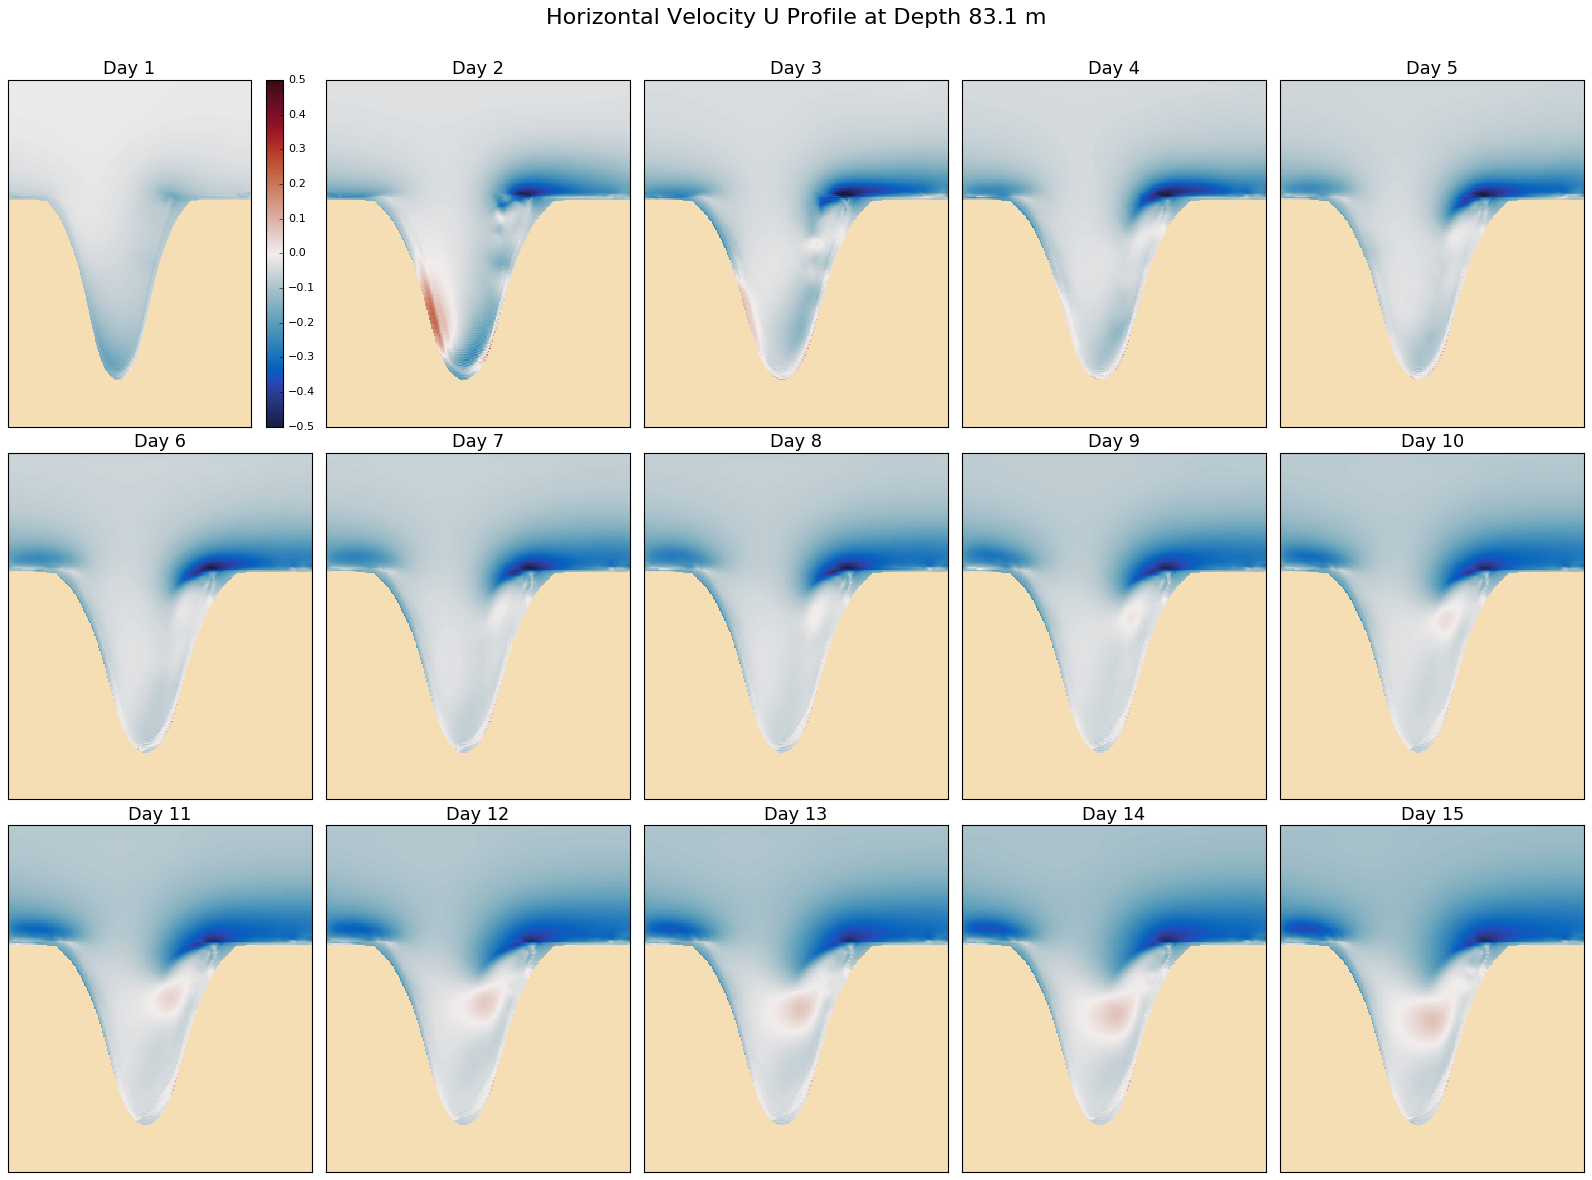

In [27]:
fig = plot_vel_snapshots(vozocrtx, xs, ys, 0.5, 'Horizontal Velocity U')

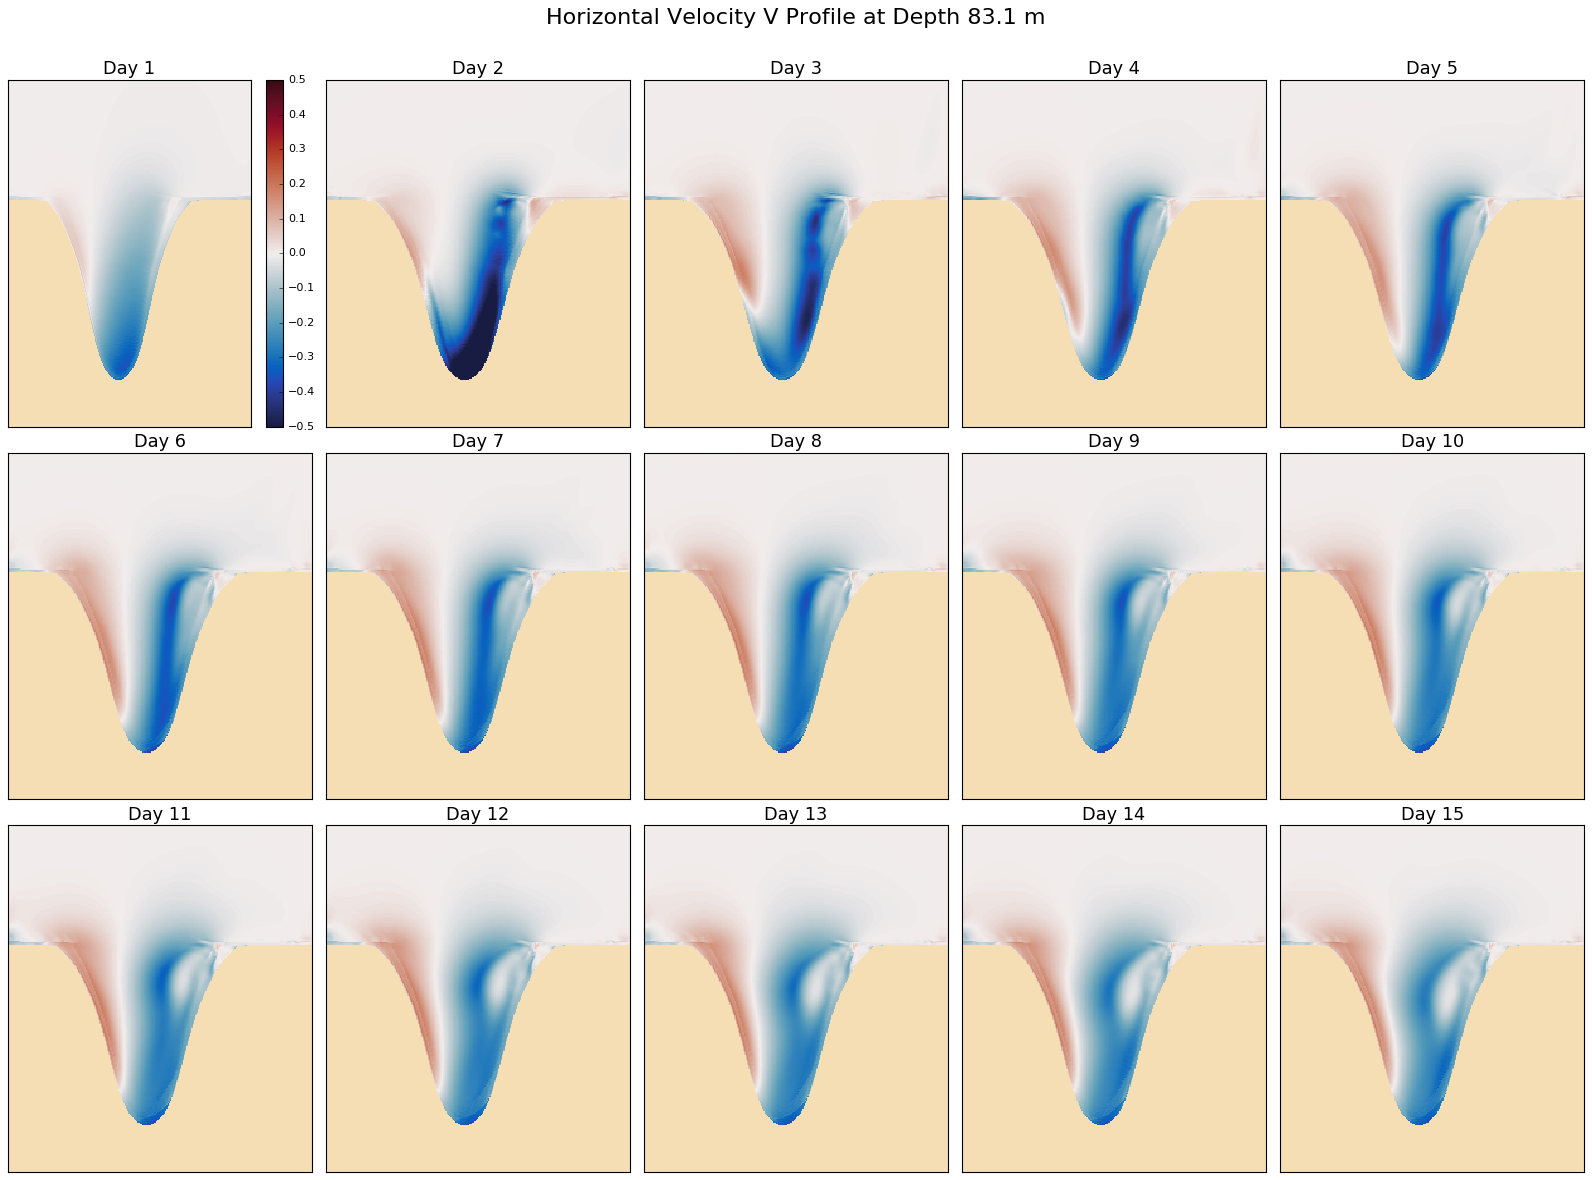

In [28]:
fig = plot_vel_snapshots(vomecrty, xs, ys, 0.5, 'Horizontal Velocity V')

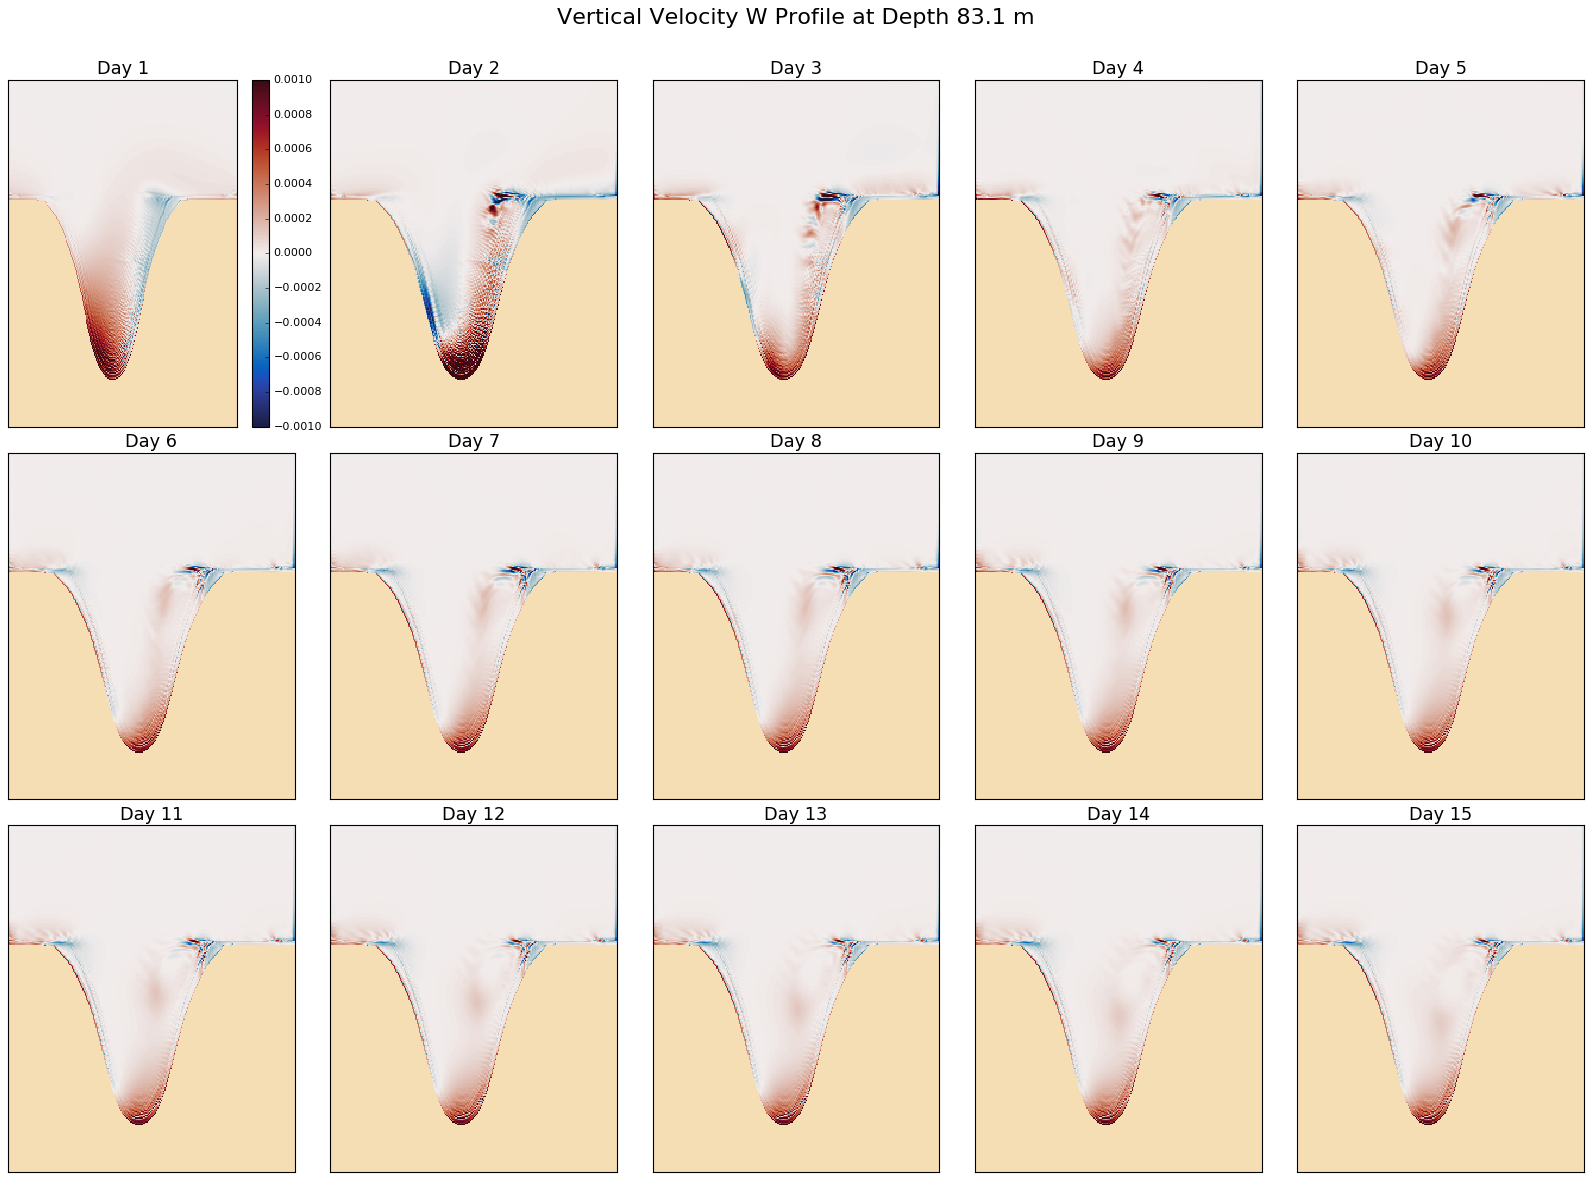

In [30]:
fig = plot_vel_snapshots(vovecrtz, xs, ys, 0.001, 'Vertical Velocity W')

In [32]:
def get_speeds(U_vel, V_vel, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[:]
    vgrid = V_vel[:]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return x_slice, y_slice, u_nstg, v_nstg, speeds

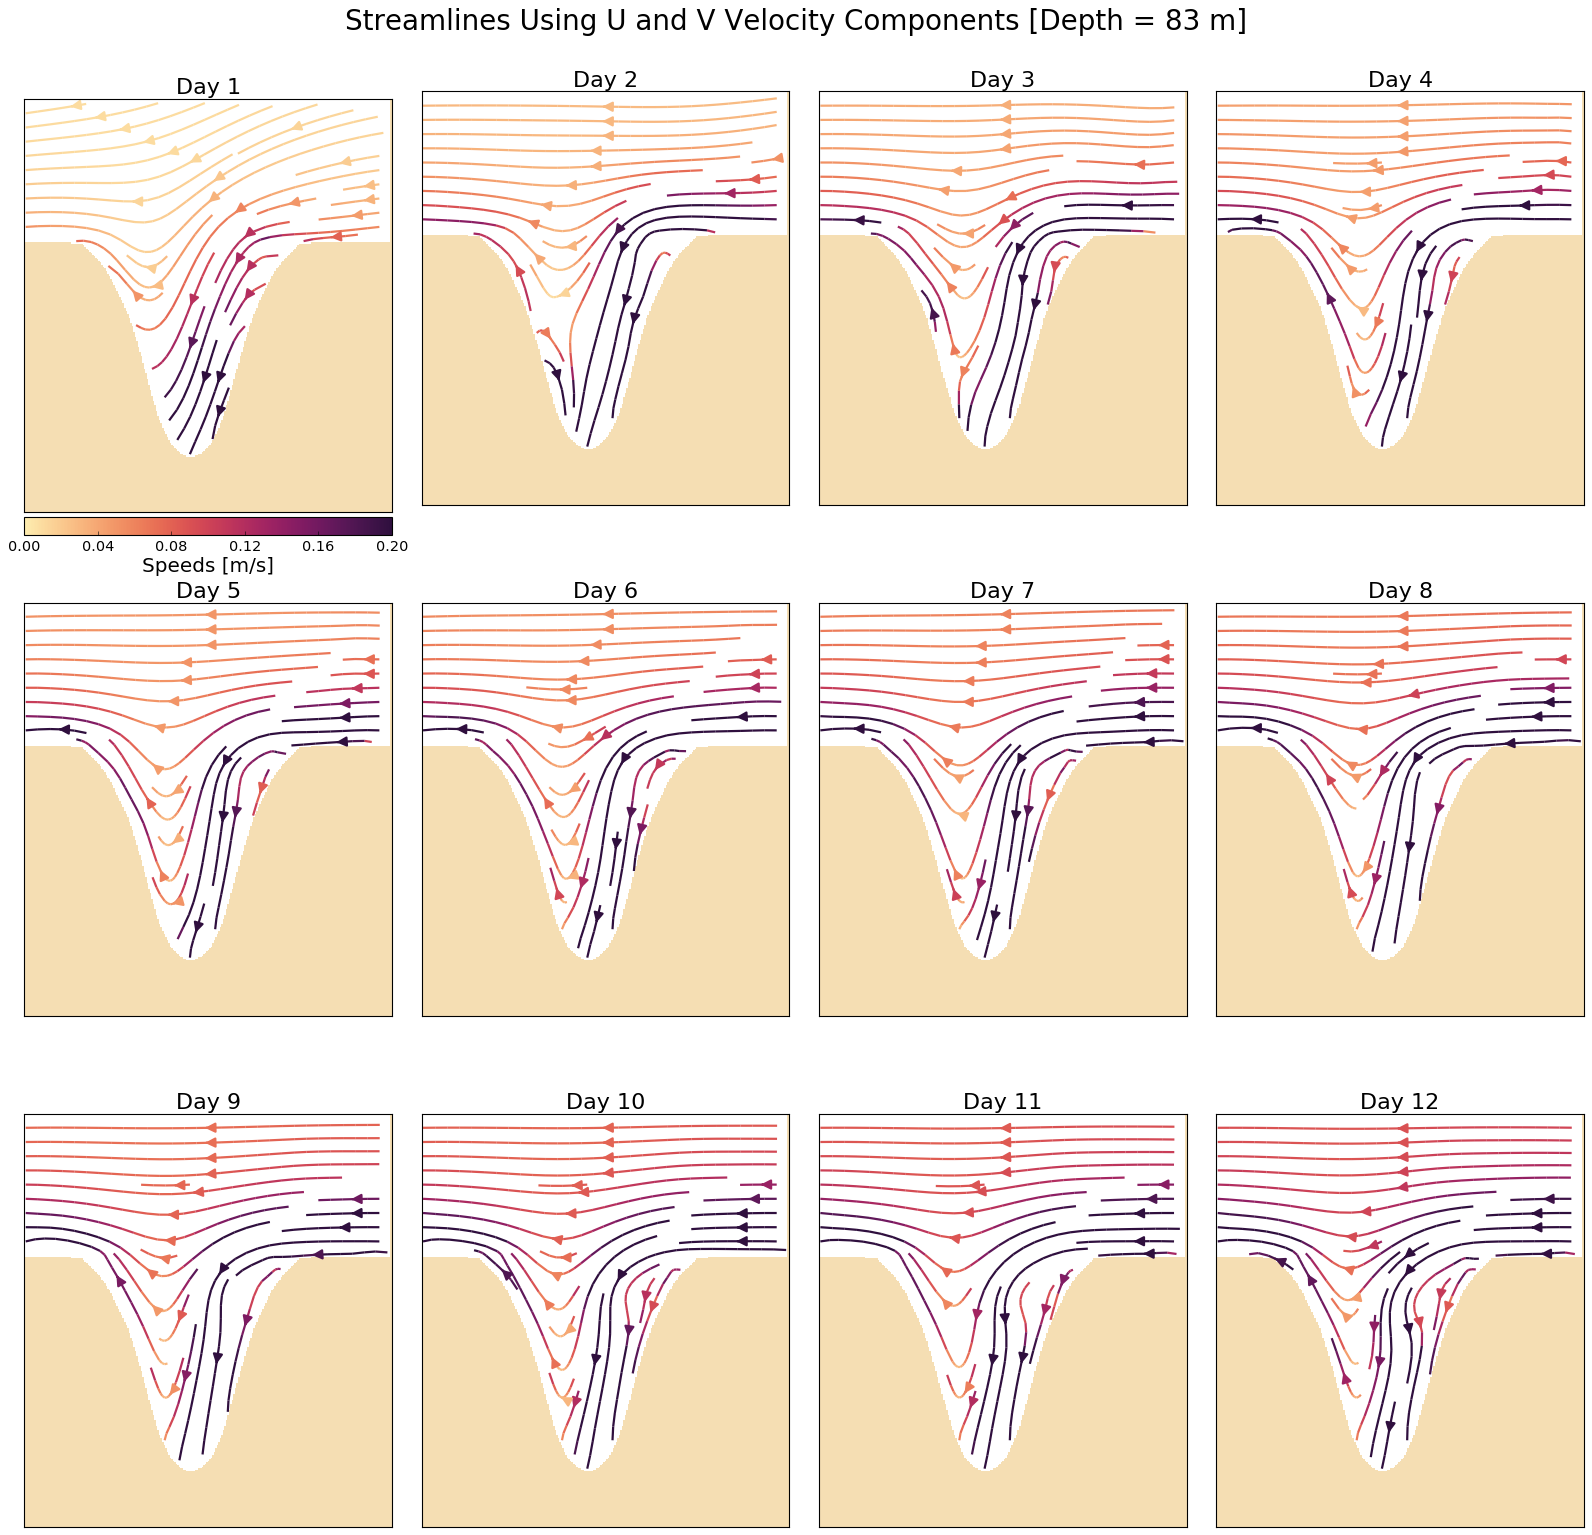

In [38]:
vmin=0
vmax=0.2
norm = mpl.colors.Normalize(vmin, vmax)

cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

fig, axes = plt.subplots(3, 4, figsize = (20, 20))
for ax, n in zip(axes.flatten(), np.arange(12)):
    U_vel = get_1day_avg(vozocrtx, n, n+1)
    V_vel = get_1day_avg(vomecrty, n, n+1)
    x_slice, y_slice, u_nstg, v_nstg, speeds = get_speeds(U_vel, V_vel, 1)
    #q = ax.quiver(x_slice, y_slice, u_nstg, v_nstg, speeds, clim=[0,0.1],
    #                      pivot='mid', cmap='Blues', width=0.003, headwidth=2, headlength=8)
    ax.pcolormesh(umask[0,:,:], cmap=cmap, zorder=1)
    strm = ax.streamplot(x_slice, y_slice, u_nstg, v_nstg, 
                         color=speeds, cmap=cmo.cm.matter, density=1, linewidth=2, norm=norm, arrowsize=2, zorder=2)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_aspect(aspect='equal')
    ax.set_xlim([0, umask.shape[-1]])
    ax.set_ylim([0, umask.shape[-2]])
    ax.set_title('Day ' + str(n+1), fontsize=20)
    if n == 0:
        cbar = fig.colorbar(strm.lines, ax=ax, fraction=0.05, orientation='horizontal', pad=0.009)
        cbar.set_label('Speeds [m/s]', fontsize=18, rotation=0, labelpad=2.5)
        cbar.ax.tick_params(labelsize=13)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        pass
fig.tight_layout(w_pad=1.2, h_pad=0.01)
fig.suptitle('Streamlines Using U and V Velocity Components [Depth = '+str(int(depthu[dep_ind]))+' m]', fontsize=25)
plt.subplots_adjust(top=0.95)

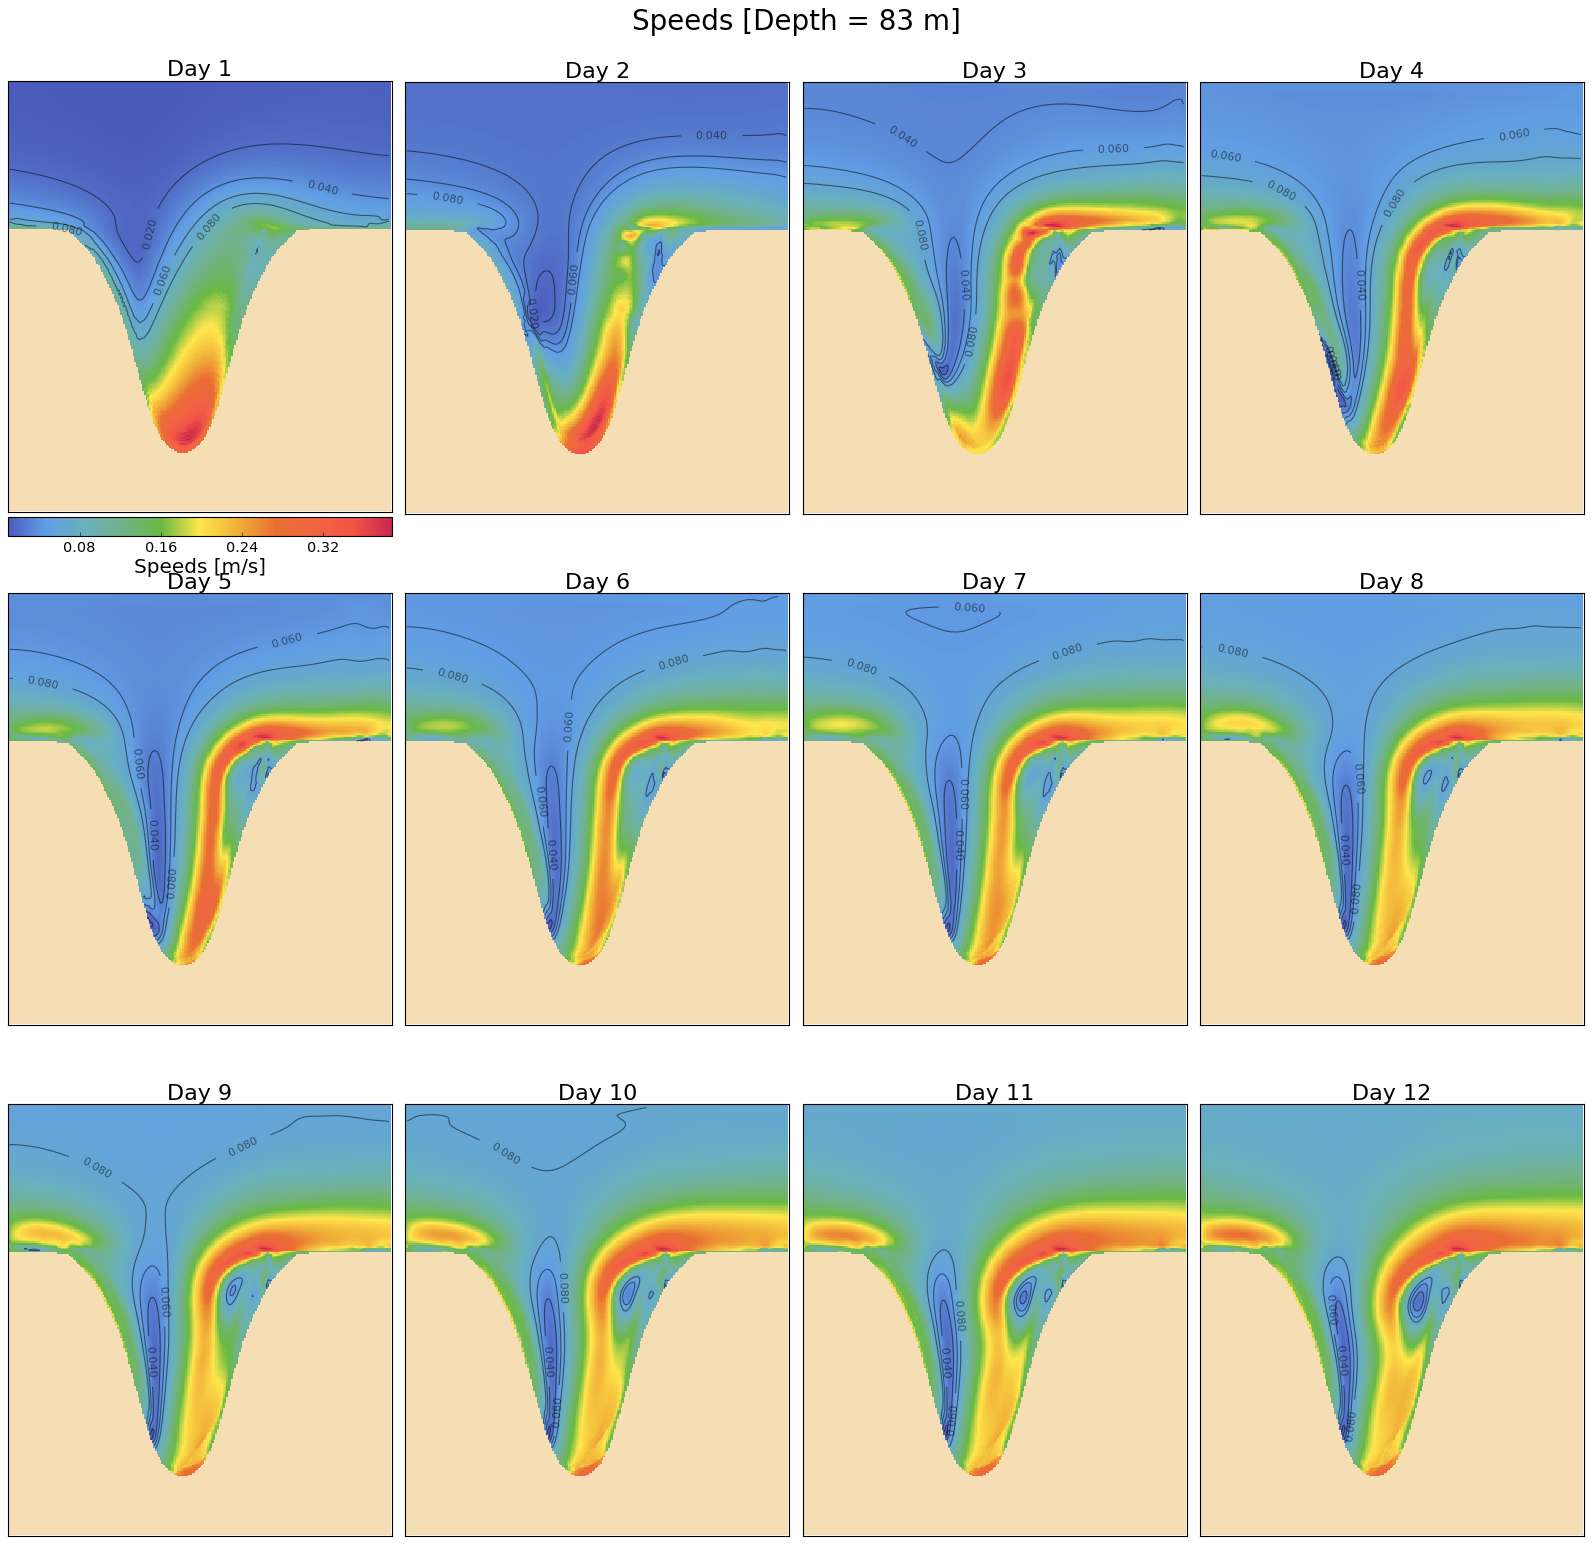

In [40]:
#cmap = plt.get_cmap(cm.Spectral_r)
colour_list = [
"#c8274c",
"#f25546",
"#F06543",
"#e96e33",
"#f0b038",
"#FFE74C",
"#69b944",
"#72b286",
"#69b0bc",
"#619ee4",
"#4b5bbb"][::-1]

cmap = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)
cmap.set_bad('wheat')

fig, axes = plt.subplots(3, 4, figsize = (20, 20))
for ax, n in zip(axes.flatten(), np.arange(12)):
    U_vel = get_1day_avg(vozocrtx, n, n+1)
    V_vel = get_1day_avg(vomecrty, n, n+1)
    x_slice, y_slice, u_nstg, v_nstg, speeds = get_speeds(U_vel, V_vel, 1)
    levels = np.arange(0, 0.1, 0.02)
    
    #ax.add_patch(patches.Rectangle((50, 50),30,30, facecolor=colour_list[n]))
    
    p = ax.pcolormesh(x_slice, y_slice, speeds, cmap=cmap)
    cs = ax.contour(x_slice, y_slice, speeds, levels = levels, colors='k', alpha=0.5)
    ax.clabel(cs, inline=1, fontsize=10)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_aspect(aspect='equal')
    ax.set_xlim([0, umask.shape[-1]])
    ax.set_ylim([0, umask.shape[-2]])
    ax.set_title('Day ' + str(n+1), fontsize=20)
    if n == 0:
        cbar = fig.colorbar(p, ax=ax, fraction=0.05, orientation='horizontal', pad=0.009)
        cbar.set_label('Speeds [m/s]', fontsize=18, rotation=0, labelpad=2.5)
        cbar.ax.tick_params(labelsize=13)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        pass
fig.tight_layout(w_pad=1.2, h_pad=0.01)
fig.suptitle('Speeds [Depth = '+str(int(depthu[dep_ind]))+' m]', fontsize=25)
plt.subplots_adjust(top=0.95)